In [42]:
import os
from utils import *
from align_and_merge import *
import matplotlib.pyplot as plt
import time
from main import *
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# TODO: Increase to 10 images
image_names = ["c1b1_20150226_144326_422", "0127_20161107_171749_524", "33TJ_20150607_135208_428", "0543_20150918_143723_450", "4WBR_20150516_112748_501", "6G7M_20150307_163718_374", "c483_20150901_105412_265", "5066_20160722_183026_986", "0218_20141031_195419_627", "0039_20141007_135645_851"]

In [44]:
our_rgb_images = []
gt_rgb_images = []

In [45]:
def parallel_process_image_for_psnr(image_name):
    folder_path = folder_names(image_name)[0]
    dng_files_path = ['{}/{}'.format(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".dng")]

    raw_images = load_raw_images_parallel(image_name)
    # ref_image_index = parallel_select_reference_image(raw_images)
    ref_image_index = load_ground_truth_reference_image_index(image_name)

    # Ground truth
    gt_image_path = '../../Dataset/20171106_subset/results_20161014/{}/merged.dng'.format(image_name)
    gt_bayer = load_raw_images([gt_image_path])[0]
    gt_rgb = get_rgb_values(gt_image_path, bayer_array=gt_bayer, no_auto_bright=False, use_camera_wb=True)

    # Naive implementation
    naive_merged_bayer = naive_align(raw_images)
    naive_merged_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=naive_merged_bayer, no_auto_bright=False, use_camera_wb=True)

    # One reference image
    ref_image = raw_images[ref_image_index]
    ref_image_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=ref_image, no_auto_bright=False, use_camera_wb=True)

    # Our implementation
    final_merged_bayer = parallel_align_and_merge_channel(raw_images, ref_image_index)
    final_merged_rgb =  get_rgb_values(dng_files_path[ref_image_index],  bayer_array=final_merged_bayer, no_auto_bright=False, use_camera_wb=True)
    
    return gt_rgb, gt_bayer, naive_merged_rgb, naive_merged_bayer, ref_image_rgb, ref_image, final_merged_rgb, final_merged_bayer
    


In [46]:
psnr_metric = [0] * 3 # One_Ref, Naive, Ours
ssim_metric = [0] * 3 # One_Ref, Naive, Ours
start = time.time()
for image_name in image_names:
    gt_rgb, gt_bayer, naive_merged_rgb, naive_merged_bayer, one_ref_image_rgb, one_ref_image, final_merged_rgb, final_merged_bayer = parallel_process_image_for_psnr(image_name)
    
    if gt_rgb.shape != final_merged_rgb.shape:
        gt_rgb = cv2.resize(gt_rgb, (final_merged_rgb.shape[1], final_merged_rgb.shape[0]))
    
    print("One Ref Image Shape: ", one_ref_image_rgb.shape, "GT Shape: ", gt_rgb.shape)
    one_ref_psnr = peak_signal_noise_ratio(gt_rgb, one_ref_image_rgb, data_range=255)
    one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
    psnr_metric[0] += one_ref_psnr
    ssim_metric[0] += one_ref_ssim

    naive_psnr = peak_signal_noise_ratio(gt_rgb, naive_merged_rgb, data_range=255)
    naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
    psnr_metric[1] += naive_psnr
    ssim_metric[1] += naive_ssim

    ours_psnr = peak_signal_noise_ratio(gt_rgb, final_merged_rgb, data_range=255)
    our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)
    ssim_metric[2] += our_ssim
    psnr_metric[2] += ours_psnr

    our_rgb_images.append(final_merged_rgb)
    gt_rgb_images.append(gt_rgb)

    print("One Ref PSNR: ", one_ref_psnr)
    print("Naive PSNR: ", naive_psnr)
    print("Ours PSNR: ", ours_psnr)
    
    print("\nOne Ref SSIM: ", one_ref_ssim)
    print("Naive SSIM: ", naive_ssim)
    print("Ours SSIM: ", our_ssim)

print("Time taken: ", time.time() - start)

downsampled raw images with shape:  (1232, 1640) previous shape:  (2464, 3280)
pyramid shapes:  [(19, 25), (77, 102), (308, 410), (1232, 1640)]
Time taken for parallel alignment:  0.6017305850982666
(10, 2464, 3280, 3) (10, 2464, 3280)
Time taken for parallel alignment:  0.41292595863342285


100%|██████████| 154/154 [00:10<00:00, 15.31it/s]


Time taken for parallel merge:  10.062788486480713
One Ref Image Shape:  (2464, 3280, 3) GT Shape:  (2464, 3280, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  28.676854168906672
Naive PSNR:  20.47111588653097
Ours PSNR:  25.866277328034855

One Ref SSIM:  0.8386516466217002
Naive SSIM:  0.660996409767307
Ours SSIM:  0.8094393235526693
downsampled raw images with shape:  (1522, 2024) previous shape:  (3044, 4048)
pyramid shapes:  [(23, 31), (95, 126), (380, 506), (1522, 2024)]
Time taken for parallel alignment:  0.8487362861633301
(9, 3044, 4048, 3) (9, 3044, 4048)
Time taken for parallel alignment:  0.5815706253051758


100%|██████████| 191/191 [00:19<00:00,  9.90it/s]


Time taken for parallel merge:  19.288947105407715
One Ref Image Shape:  (3044, 4048, 3) GT Shape:  (3044, 4048, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  30.163896203262045
Naive PSNR:  28.78822656476618
Ours PSNR:  32.511539019438075

One Ref SSIM:  0.6687889170894611
Naive SSIM:  0.8517867789709687
Ours SSIM:  0.909261871473773
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  1.1833155155181885
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  0.7481379508972168


100%|██████████| 195/195 [00:19<00:00,  9.75it/s]


Time taken for parallel merge:  19.99189782142639
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  33.026203280787534
Naive PSNR:  32.855170179360606
Ours PSNR:  36.39615245805009

One Ref SSIM:  0.7879466818782928
Naive SSIM:  0.9158389298843147
Ours SSIM:  0.9542236831495452
downsampled raw images with shape:  (1512, 2016) previous shape:  (3024, 4032)
pyramid shapes:  [(23, 31), (94, 126), (378, 504), (1512, 2016)]
Time taken for parallel alignment:  0.7813372611999512
(8, 3024, 4032, 3) (8, 3024, 4032)
Time taken for parallel alignment:  0.6534957885742188


100%|██████████| 189/189 [00:22<00:00,  8.34it/s]


Time taken for parallel merge:  22.67218852043152
One Ref Image Shape:  (4032, 3024, 3) GT Shape:  (4032, 3024, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  40.065075265197066
Naive PSNR:  23.912769498789594
Ours PSNR:  33.09543132009318

One Ref SSIM:  0.948789434356197
Naive SSIM:  0.7834021408826016
Ours SSIM:  0.9166723768869437
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  1.069737195968628
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  0.7395157814025879


100%|██████████| 195/195 [00:18<00:00, 10.29it/s]


Time taken for parallel merge:  18.961201429367065
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  25.341034329837345
Naive PSNR:  25.719652543767502
Ours PSNR:  25.491831087353898

One Ref SSIM:  0.7104031369144627
Naive SSIM:  0.8290961996737211
Ours SSIM:  0.8369426800570295
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  0.8379466533660889
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  0.7918846607208252


100%|██████████| 195/195 [00:27<00:00,  7.04it/s]


Time taken for parallel merge:  27.714664220809937
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  27.503209381949514
Naive PSNR:  27.503521431371457
Ours PSNR:  28.24443479985745

One Ref SSIM:  0.6430053461082096
Naive SSIM:  0.7690666130932574
Ours SSIM:  0.7817524909798972
downsampled raw images with shape:  (1514, 2040) previous shape:  (3028, 4080)
pyramid shapes:  [(23, 31), (94, 127), (378, 510), (1514, 2040)]
Time taken for parallel alignment:  0.797715425491333
(10, 3028, 4080, 3) (10, 3028, 4080)
Time taken for parallel alignment:  0.6476774215698242


100%|██████████| 190/190 [00:21<00:00,  8.88it/s]


Time taken for parallel merge:  21.39777159690857
One Ref Image Shape:  (3028, 4080, 3) GT Shape:  (3028, 4080, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  24.01653970281877
Naive PSNR:  26.126679927099445
Ours PSNR:  24.075502045110593

One Ref SSIM:  0.6958130682829514
Naive SSIM:  0.7955024527099459
Ours SSIM:  0.7947976823070128
downsampled raw images with shape:  (1512, 2016) previous shape:  (3024, 4032)
pyramid shapes:  [(23, 31), (94, 126), (378, 504), (1512, 2016)]
Time taken for parallel alignment:  0.47486162185668945
(3, 3024, 4032, 3) (3, 3024, 4032)
Time taken for parallel alignment:  0.16013431549072266


100%|██████████| 189/189 [00:09<00:00, 19.28it/s]


Time taken for parallel merge:  9.821678638458252
One Ref Image Shape:  (3024, 4032, 3) GT Shape:  (3024, 4032, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  38.34909603427687
Naive PSNR:  35.015402369980265
Ours PSNR:  34.98008975752567

One Ref SSIM:  0.9144306184735119
Naive SSIM:  0.9046332590574625
Ours SSIM:  0.8931692937936527
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  0.9123420715332031
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  0.7047569751739502


100%|██████████| 195/195 [00:24<00:00,  8.08it/s]


Time taken for parallel merge:  24.150232315063477
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  21.57732762543411
Naive PSNR:  28.534476906553348
Ours PSNR:  30.47991876111722

One Ref SSIM:  0.1853446485262468
Naive SSIM:  0.5367525212935381
Ours SSIM:  0.7027492447682562
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  0.8879647254943848
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  1.012834072113037


100%|██████████| 195/195 [00:25<00:00,  7.62it/s]


Time taken for parallel merge:  25.59074306488037
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_15784\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  28.218748036049387
Naive PSNR:  28.610265358789512
Ours PSNR:  28.735743631674072

One Ref SSIM:  0.7446399815412482
Naive SSIM:  0.8482498940997883
Ours SSIM:  0.8470266975885674
Time taken:  535.1692798137665


In [49]:
ssim_metric = np.array(ssim_metric) / len(image_names)
psnr_metric = np.array(psnr_metric) / len(image_names)

In [50]:
print("PSNR METRIC")
print("One Ref: ", psnr_metric[0])
print("Naive: ", psnr_metric[1])
print("Ours: ", psnr_metric[2])

print("\nSSIM METRIC")
print("One Ref: ", ssim_metric[0])
print("Naive: ", ssim_metric[1])
print("Ours: ", ssim_metric[2])

PSNR METRIC
One Ref:  2.969379840285193
Naive:  2.775372806670089
Ours:  2.9987692020825514

SSIM METRIC
One Ref:  0.07137813479792281
Naive:  0.07895325199432904
Ours:  0.08446035344557347


## Diff Images

0
1
2
3
4
5
6
7
8
9


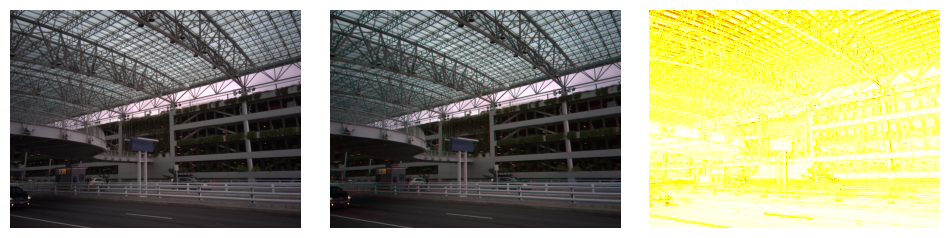

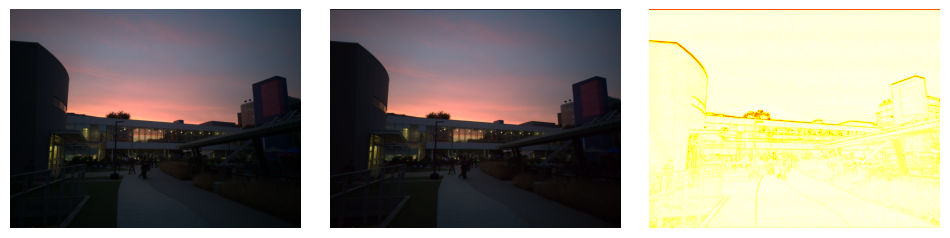

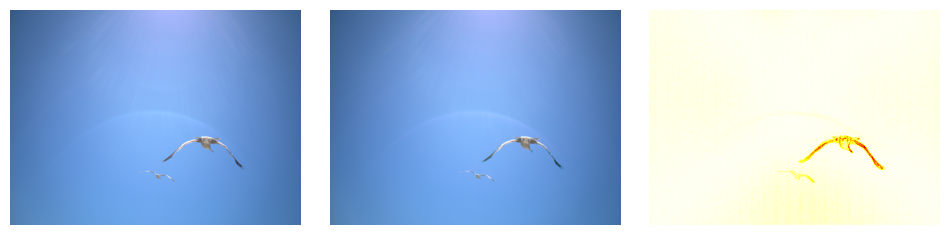

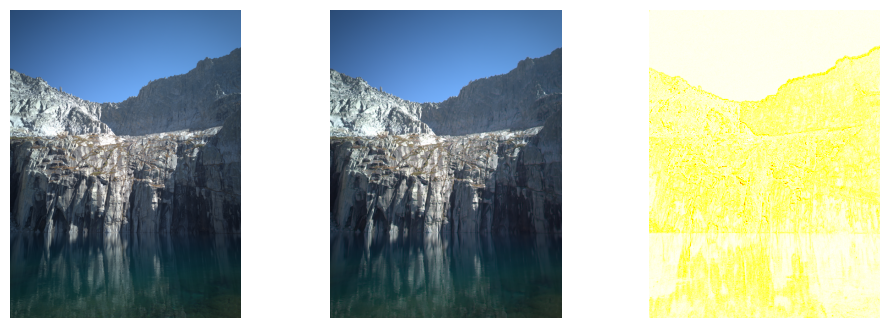

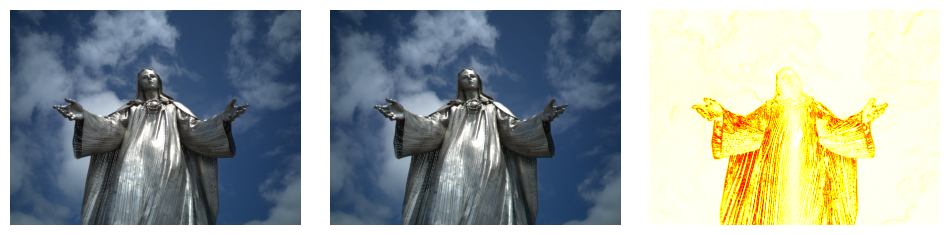

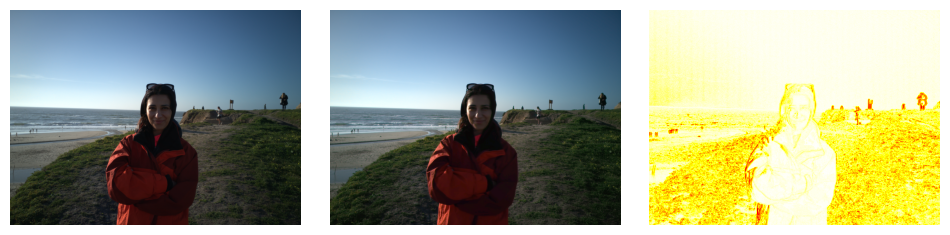

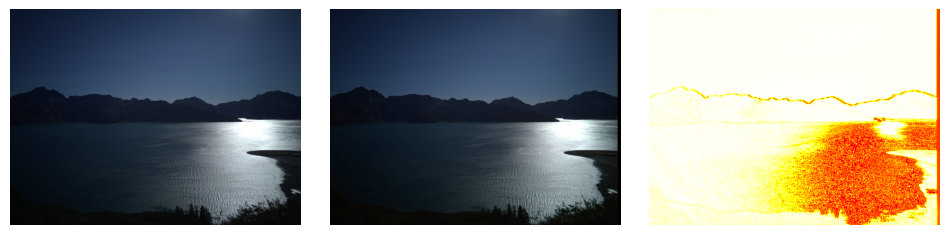

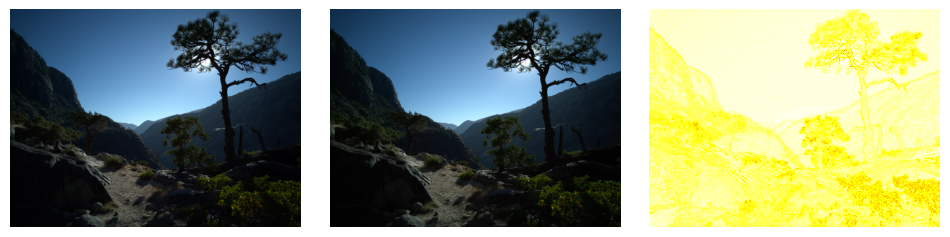

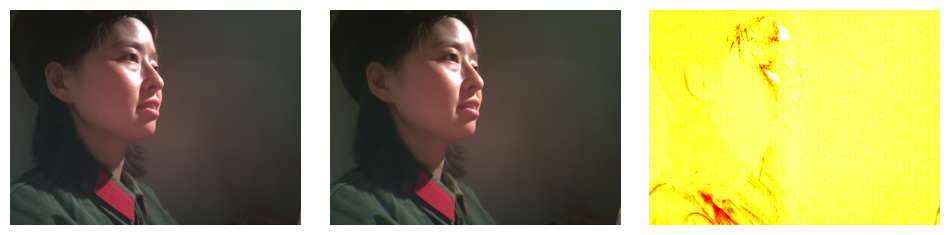

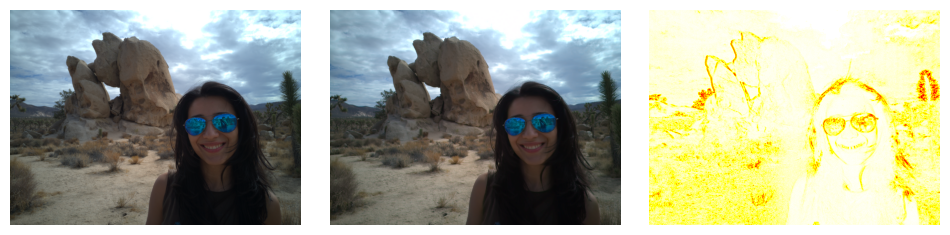

In [75]:
for i in range(len(our_rgb_images)):
    diff, diff_image = structural_similarity(our_rgb_images[i], gt_rgb_images[i], channel_axis=-1, data_range=255, full=True)
    diff_image += 1.0
    diff_image /= 2.0
    # diff_image *= 255
    # diff_image = diff_image.astype(np.uint8)
    # print(diff_image.shape)

    # print(diff_image.max(), diff_image.min())
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Set the spacing between the images
    fig.subplots_adjust(wspace=0.1, hspace=0)

    # Display the images on the axes
    ax[0].imshow(gt_rgb_images[i])
    ax[1].imshow(our_rgb_images[i])
    ax[2].imshow(np.linalg.norm(diff_image, axis=-1), cmap='hot')

    # Remove the axis labels and ticks
    for a in ax:
        a.axis('off')

    # Show the grid of images
    plt.savefig('./paper_illustrations/{}_comparison.png'.format(i))
    print(i)
    # break

In [119]:
x_diff = 80
y_diff = 110
image_1 = plt.imread('./paper_illustrations/0_comparison.png')[x_diff:-x_diff,y_diff+30:-y_diff,:3]
image_2 = plt.imread('./paper_illustrations/1_comparison.png')[x_diff:-x_diff,y_diff+30:-y_diff,:3]
image_3 = plt.imread('./paper_illustrations/3_comparison.png')[x_diff:-x_diff//2,y_diff+30:-y_diff,:3]
numpy_vertical = np.vstack((image_1, image_2, image_3)) * 255
numpy_vertical = numpy_vertical.astype(np.uint8)
image = Image.fromarray(numpy_vertical)
image.save('./paper_illustrations/combined_comparison.png')